# ORIE 4741 Project
### Netflix Success Predictor

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import RocCurveDisplay, recall_score, precision_score, roc_curve, roc_auc_score, balanced_accuracy_score
import matplotlib.pyplot as plt
import matplotlib as mpl

In [64]:
netflix=pd.read_csv('datasets/netflix.csv')

In [65]:
netflix.head()

,show_title,type,weekly_hours_viewed,weekly_views,cumulative_weeks_in_top_10,runtime,number_of_seasons,language,is_staggered_launch,available_globally,release_date,genre,main_production,week
0,'83,Films,6825000.0,NaN,2,NaN,NaN,Non-English,False,No,NaN,NaN,NaN,2022-04-03
1,10 Days of a Bad Man,Films,6900000.0,3300000.0,2,4.1334,NaN,Non-English,False,NaN,NaN,NaN,NaN,2023-08-27
2,10 Days of a Good Man,Films,7415000.0,NaN,2,NaN,NaN,Non-English,False,NaN,NaN,NaN,NaN,2023-03-12
3,1000 Miles from Christmas,Films,6795000.0,NaN,2,NaN,NaN,Non-English,False,NaN,NaN,NaN,NaN,2022-01-02
4,12 Strong,Films,8210000.0,NaN,2,NaN,NaN,English,False,No,NaN,NaN,NaN,2022-07-24


## Feature Engineering
Before we create a model in order to understand the features of importance for Netflix streaming content success and use it to predict how many views a show/film gets, we need to inspect the data and utilize feature engineering tools. 

#### Dealing with NaN values: 

In [66]:
def size_if_na_dropped(df):
  print(f"Out of {df.shape[0]} total points, if we drop all with missing data, \
we'll have {df.dropna().shape[0]} points (or {df.dropna().shape[0]/df.shape[0]} \
  of the original dataset)")

size_if_na_dropped(netflix)

Out of 1865 total points, if we drop all with missing data, we'll have 0 points (or 0.0   of the original dataset)


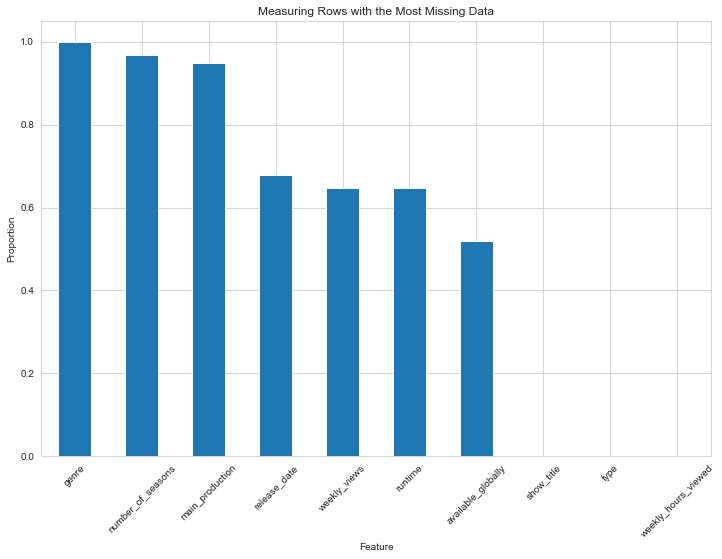

In [67]:
def plot_na(df):
  sns.set_style('whitegrid')
  plt.figure(figsize=(12,8))
  missing_vals = df.isna().sum()/df.shape[0]
  missing_vals = missing_vals.sort_values(ascending=False)[0:10]
  ax = missing_vals.plot(kind='bar')

  ax.set_title('Measuring Rows with the Most Missing Data')
  ax.set_ylabel('Proportion')
  ax.set_xlabel('Feature')
  ax.tick_params(axis='x', rotation=45)

plot_na(netflix)

Out of 1865 total points, if we drop all with missing data, we'll have 0 points (or 0.0   of the original dataset)


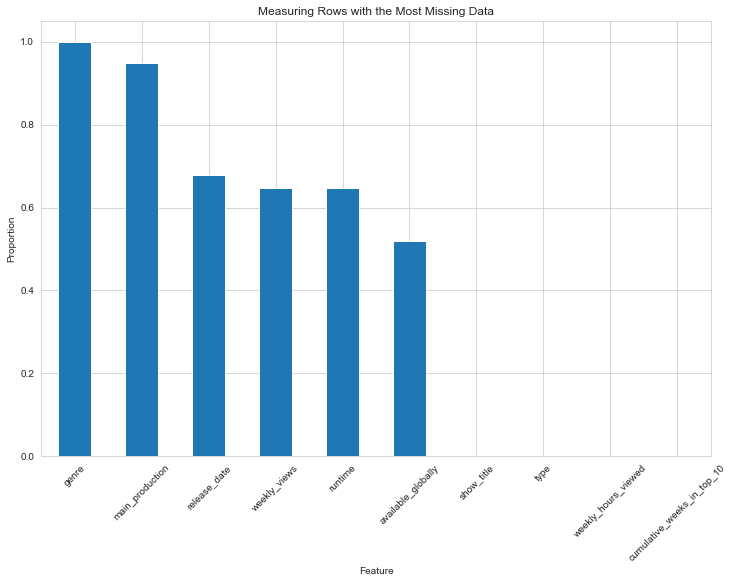

In [68]:
#The NaN values of number_of_seasons occur b/c they are films not shows, impute with 0
netflix['number_of_seasons'] = netflix['number_of_seasons'].fillna(0)
plot_na(netflix)
size_if_na_dropped(netflix)

In [69]:
encoded_df= pd.get_dummies(netflix[['language','type','is_staggered_launch','available_globally' ]])
netflix = pd.concat([netflix.drop(columns=['language','type','is_staggered_launch','available_globally' ]), encoded_df], axis=1)
netflix

,show_title,weekly_hours_viewed,weekly_views,cumulative_weeks_in_top_10,runtime,number_of_seasons,release_date,genre,main_production,week,is_staggered_launch,language_English,language_Non-English,type_Films,type_TV,available_globally_No,available_globally_Yes
0,'83,6.825000e+06,NaN,2,NaN,0.0,NaN,NaN,NaN,2022-04-03,False,0,1,1,0,1,0
1,10 Days of a Bad Man,6.900000e+06,3300000.0,2,4.1334,0.0,NaN,NaN,NaN,2023-08-27,False,0,1,1,0,0,0
2,10 Days of a Good Man,7.415000e+06,NaN,2,NaN,0.0,NaN,NaN,NaN,2023-03-12,False,0,1,1,0,0,0
3,1000 Miles from Christmas,6.795000e+06,NaN,2,NaN,0.0,NaN,NaN,NaN,2022-01-02,False,0,1,1,0,0,0
4,12 Strong,8.210000e+06,NaN,2,NaN,0.0,NaN,NaN,NaN,2022-07-24,False,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860,maboroshi,2.400000e+06,1300000.0,1,1.8500,0.0,NaN,NaN,NaN,2024-01-21,False,0,1,1,0,0,0
1861,¡Que viva México!,1.249250e+07,NaN,4,NaN,0.0,2023-05-11,NaN,NaN,2023-06-04,False,0,1,1,0,0,1
1862,Ìjọ̀gbọ̀n,4.950000e+06,2550000.0,2,3.8666,0.0,NaN,NaN,NaN,2023-10-22,False,0,1,1,0,0,0
1863,أصحاب ...ولا أعزّ,2.910000e+06,NaN,3,NaN,0.0,2022-01-20,NaN,NaN,2022-02-06,False,0,1,1,0,1,0


#### Dealing with na for runtime variable
The variable runtime still has a lot of missing values so will impute mean values
- For films, we will impute the value with the mean runtime for films. 
- For TV shows, we will impute the value with the mean runtime of tv shows with the same number of seasons

MAYBE MATRIX COMPLETION

#### Dealing with Categorical Values
There are a few categorical features in our data. To deal with them we will do the following
- One hot encoding the binary values: Language, Type, Available Globally
- Multi-hot encoding genre list

#### Standardizing
Our metric to determine success is weekly views, however, the runtime of the content may affect this (for example, a show that has multiple episodes will likely get more views than one individual film) to account for that, we want to standardize our data. 
Options
- Standardize
- Normalize
- divide by runtime (and then delete runtime from the df since it would be a covariate)